### Import necessary packages

In [1]:
import numpy as np
import pandas as pd
from ntpath import basename
from natsort import natsorted
import os, glob, shutil
import importlib
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.spatial.distance import pdist, squareform
import scipy.cluster.hierarchy as sch
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

import negFIN as nf

# This function is used to list all subfolders in a folder
def list_folders(folder_path):
    return natsorted(glob.glob(os.path.join(folder_path, '*')))

# This function is used to list all files of a specific type in a folder 
def list_files(folder_path,file_type):
    return natsorted(glob.glob("{}/*.{}".format(folder_path,file_type)))

# This function is used to make a new folder/directory
# Note that if folder_path exists then remove this folder and its subfolders
def makedirs(folder_path):
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    else:
        shutil.rmtree(folder_path)  # Removes all the subdirectories!
        os.makedirs(folder_path)

### Run the negFIN algorithm to find all FIs for each dataset from this cell

In [ ]:
folders = list_folders("input_datasets")

for i in range(len(folders)):
    # Create the output folder to maintain the mining results for each dataset
    print(folders[i])
    output_folder = "outputs/{}".format(basename(folders[i]))
    makedirs(output_folder)
    files = list_files(folders[i],"txt")
    # This is the relative support
    minsup = 0.1

    # If you want to use the absolute support, declare minSup>1, for example:
    # minSup = 50

    for j in range(len(files)):
        input_file = files[j]
        print(input_file)
        importlib.reload(nf)
        nf.runAlgorithm(input_file,minsup,"{}/{}".format(output_folder,basename(input_file)))

### Post processing

In [ ]:
def summarize_result_new(input_folder,cities):
    # FIRST ROUND: traverse cities to get the list of city names (they will be rows in the data frame) and FIs (they will be columns in the data frame)
    FI_list = []
    city_list = []
    city_index = []
    files = list_files(input_folder,"txt")
    for i in range(len(files)):
        file_name = basename(files[i])
        start_pos = file_name.find("_") + 1
        end_pos = file_name.find("_UA2018")
        city_name = file_name[start_pos:end_pos].rsplit('_', 2)[-3:]
        city_name = '_'.join(city_name)
        if cities == 'all_city' or city_name in cities:
            city_list.append(city_name)
            city_index.append(i)
            # scan the file
            with open(files[i], 'r') as reader:
                for line in reader:
                    # Put the FI into the FI_list
                    sup_pos = line.find("#SUP")
                    raw_FI = line[:sup_pos].strip()
                    # Process the raw_FI to ensure it's sorted
                    processed_FI = ' '.join(sorted(raw_FI.split()))
                    FI_list.append(processed_FI)
    print("Total of cities:",len(city_list))
    print("Total of FIs in {} cities:{}".format(len(city_list),len(FI_list)))
    
    # Remove the duplication of FI in the FI_list
    unique_FI_list = list(set(FI_list)) 
    print("Total of FIs in {} cities after remove the duplicate:{}".format(len(city_list),len(unique_FI_list)))

    # Sort all FIs in the unique_FI_list according to their name and length
    unique_sorted_FI_list = sorted(unique_FI_list, key=lambda s: (len(s), s))
    # Create a data frame that get city_list for rows and unique_FI_list for columns
    df_city_FI = pd.DataFrame(0, index=city_list, columns=unique_sorted_FI_list)
    print(df_city_FI.shape)

    # SECOND ROUND: traverse cities to fill in values
    city_index_name_dict = dict(zip(city_index,city_list))
    for i in city_index:
        # scan the file
        with open(files[i], 'r') as reader:
            for line in reader:
                sup_pos = line.find("#SUP")
                FI = line[:sup_pos].strip()
                processed_FI = ' '.join(sorted(FI.split()))
                percentage = line.split('%:')[1].strip()
                # Fill the values
                df_city_FI.loc[city_index_name_dict[i], processed_FI] = int(percentage)/100
    print(df_city_FI.shape)
    # Save the dataframe into an excel output file
    if cities == 'all_city':
        df_city_FI.to_excel('summary_all_cities.xlsx')
    else:
        file_name = '-'.join(cities) + '.xlsx'
        df_city_FI.to_excel(file_name)
    print("Done!")


In [ ]:
summarize_result_new("outputs\Europe_100_cities_UA_2018", 'all_city')

In [ ]:
# pip install umap-learn

## Dimensionality reduction by UMAP 

In [ ]:
import umap


df_city_FI = pd.read_excel('summary_all_cities.xlsx', sheet_name='Sheet1', index_col=0).iloc[0:, 1:]

# UMAP
umap_model = umap.UMAP(n_neighbors=15, min_dist=0.1, n_components=2)
umap_coords = umap_model.fit_transform(df_city_FI)
df_embedding = pd.DataFrame(umap_coords, columns=["x_coors", "y_coors"])
df_embedding.insert(loc=0, column='city', value=list(df_city_FI.index))
df_embedding.to_csv("embedding_matrix.csv", index=False)

### Plot the scatter that attachs the cities images inside

In [ ]:
# pip install opencv-python

C:\Users\it08d\AppData\Local\Temp\ipykernel_24048\575692865.py:37: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Augsburg.jpg' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  coords_df.loc[city, 'file'] = file_name


Number of bins: 30


C:\Users\it08d\AppData\Local\Temp\ipykernel_24048\575692865.py:91: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  selected_cities_df = pd.concat([sub_df.iloc[[check_img_idx]],selected_cities_df], ignore_index=False)
c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (172955872 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\PIL\Image.py:3157: DecompressionBombWarning: Image size (89740975 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(
c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\PIL\Image.py:3157: DecompressionBombWar

Save at: outputs_HAC_normalize_SquareEuclidean_Ward/scatter_images.pdf
Done


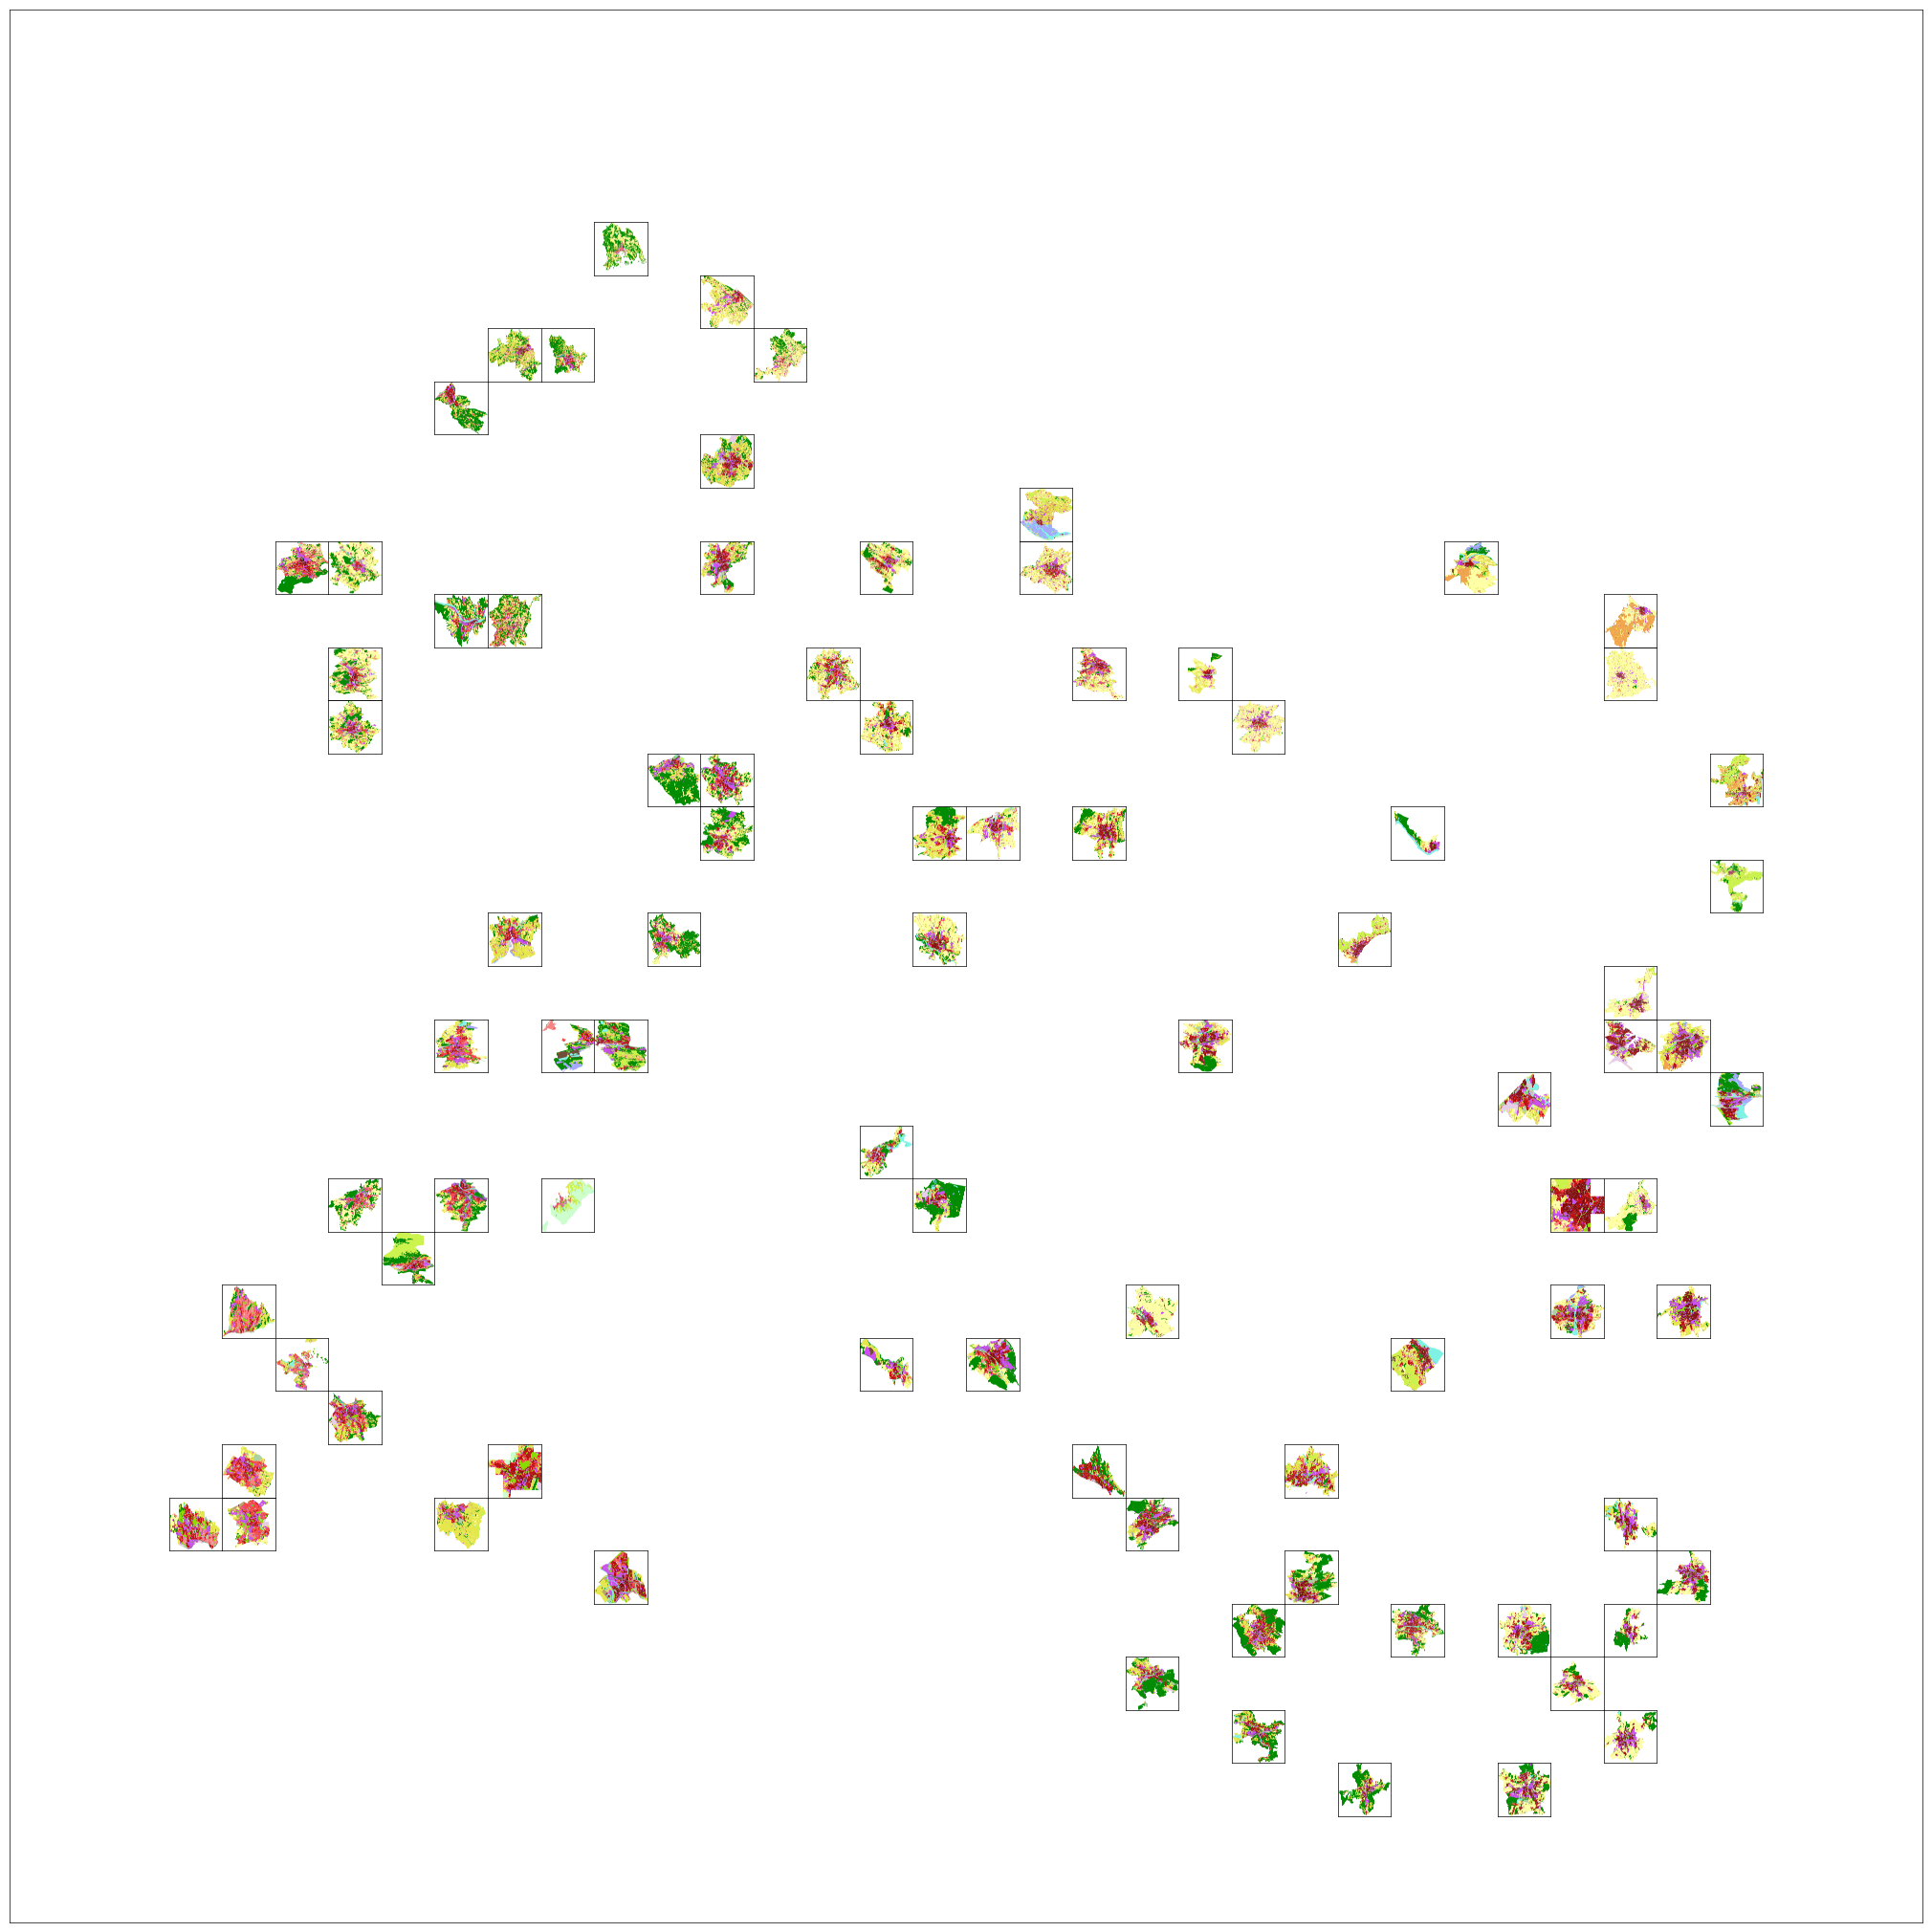

In [13]:
import gc, os
import cv2 as cv
import warnings

from matplotlib import gridspec
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, minmax_scale

# warnings.filterwarnings("ignore")

# plt.style.use('fivethirtyeight')

plt.rcParams["font.family"] = "serif"
plt.rcParams["mathtext.fontset"] = "dejavuserif"

def release_mem(fig):
    fig.clf()
    plt.close()
    gc.collect()

# Load the data
coords_df = pd.read_csv("embedding_matrix.csv", index_col=0)
coords_df.sort_index(inplace=True)

excluded_cities = ["NOVI_SAD","SHKODER","MOSTAR","PRISTINA","KUOPIO","NORRKOPING", "LIVORNO"]

# Remove excluded cities from coords_df
coords_df.drop(excluded_cities, inplace=True, errors='ignore')

img_dir = "image-compressed"
img_files = [f for f in os.listdir(img_dir) if f.endswith(".jpg")]

# Check and update the 'file' column
for file_name in img_files:
    city = file_name.split(".")[0].upper()
    if city in coords_df.index:
        coords_df.loc[city, 'file'] = file_name

# df_embedding['file'].fillna("not found", inplace=True)
coords_df.to_csv("coords.csv")

n_bins = 30
# for n_bins in range(35,36):
print("Number of bins: {}".format(n_bins))
margin = 0.1

coords = coords_df[["x_coors", "y_coors"]].values
scaler = MinMaxScaler()
coords = scaler.fit_transform(coords)

# Divide the images into bins 
bins = np.linspace(0, 1, n_bins+1)
ins_x = np.digitize(coords[:, 0], bins)
ins_x[ins_x>n_bins] = n_bins
ins_y = np.digitize(coords[:, 1], bins)
ins_y[ins_y>n_bins] = n_bins

grid_txt = ["{0}|{1}".format(ins_yi, ins_xi) for ins_xi, ins_yi in zip(ins_x, ins_y)] #transpose to adapt to the grid indices 
grid_size= 1/n_bins
n_col = n_bins + 2*int(margin/grid_size)
n_row = n_bins + 2*int(margin/grid_size)

fig = plt.figure(figsize=(20, 20))
grid = plt.GridSpec(n_row, n_col)
grid.update(wspace=0., hspace=0.)
plt.rcParams["axes.linewidth"] = 0.5
# Plot on the background 
# sns.kdeplot(x=coords[:, 0], y=coords[:, 1], shade=True, cmap="Blues")
plt.xticks([])
plt.yticks([])
# plt.xlabel('Embedding 1', fontsize=16)
# plt.ylabel('Embedding 2', fontsize=16)
# plt.box(True)

selected_cities_df = pd.DataFrame(columns=coords_df.columns)

# Show the image representing in each bin
for gt in np.unique(grid_txt):
    check_idxes = [i for i in np.arange(len(grid_txt)) if grid_txt[i]==gt]
    sub_df = coords_df.iloc[check_idxes]
    check_coords = coords[check_idxes]
    ref_coords = np.mean(check_coords, axis=0)
    check_img_idx = np.argmin(np.mean(abs(check_coords-ref_coords)))
    check_img_file = sub_df.iloc[check_img_idx]["file"]
    img = plt.imread("image-compressed/{}".format(check_img_file))

    grid_coords = np.array(gt.split("|")).astype(np.int32) - 1 + int(margin/grid_size)
    # print(check_img_file, grid_coords)

    # Append the selected city information to the DataFrame
    selected_cities_df = pd.concat([sub_df.iloc[[check_img_idx]],selected_cities_df], ignore_index=False)

    subplot_size = 10
    ax = fig.add_subplot(grid[n_row-grid_coords[0], grid_coords[1]])
    ax.margins(0, 0)
    ax.imshow(img, aspect='auto', extent=[0, subplot_size, 0, subplot_size])
    # ax.imshow(img, aspect='auto', extent=None)
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    for axis in ['top','bottom','left','right']:
        ax.spines[axis].set_linewidth(0.5)
    ax.autoscale_view('tight')

fig.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0, hspace=0)
# plt.gcf().set_facecolor("white")
plt.margins(x=0.05, y=0.05)

output_folder = "outputs_HAC_normalize_SquareEuclidean_Ward"
# makedirs(output_folder)
save_file = "{}/scatter_images.pdf".format(output_folder)
plt.savefig(save_file, transparent=False, dpi=1000)
print('Save at: {}'.format(save_file))
# release_mem(fig)
# Save the DataFrame with selected cities
selected_cities_df.to_csv("selected_cities.csv", index=False)
print("Done")

### Plot the heatmap and HAC based on the UMAP coordinates

c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,
c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\seaborn\matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
c:\Users\it08d\.conda\envs\eda_f2023\lib\site-packages\seaborn\matrix.py:530: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(self.array, method=self.method,


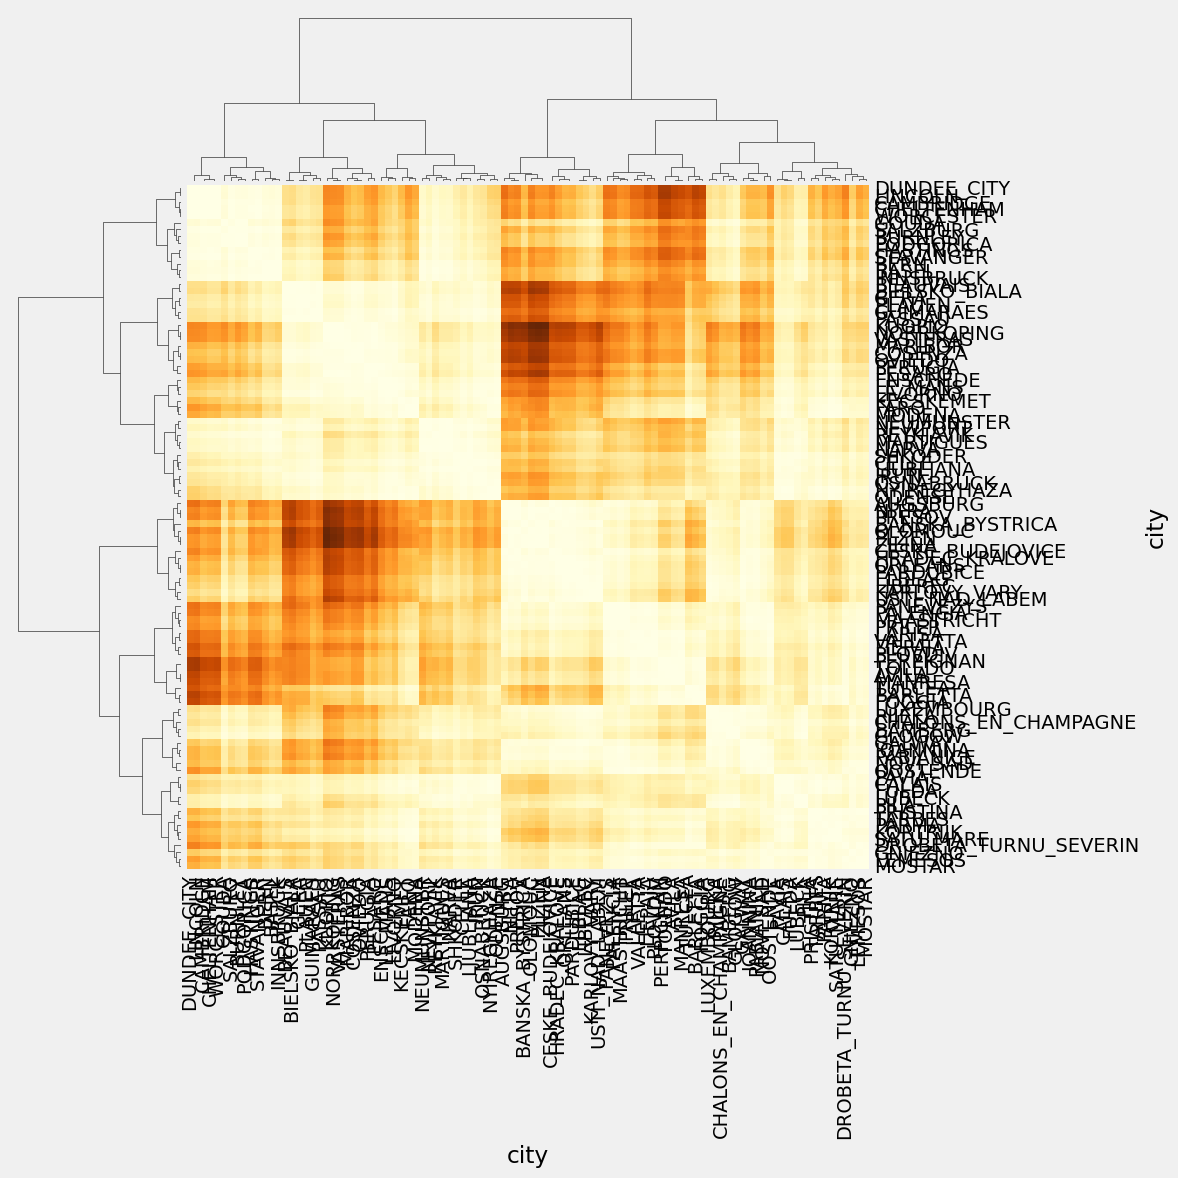

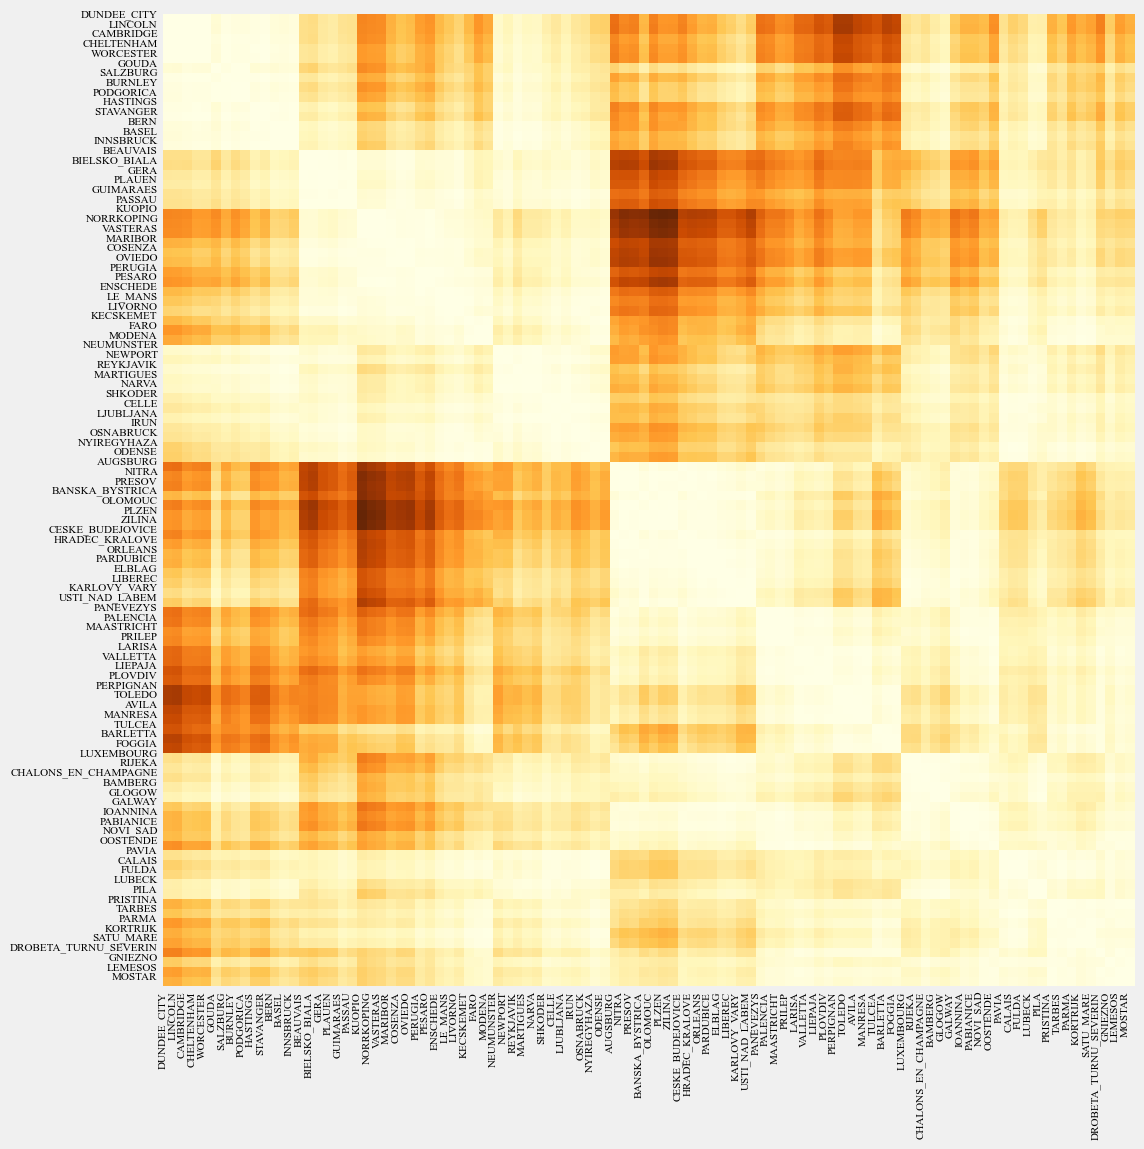

In [5]:
plt.style.use('fivethirtyeight')
output_folder = "outputs_HAC_normalize_SquareEuclidean_Ward"
makedirs(output_folder)

# Load the data
coords_df = pd.read_csv("embedding_matrix.csv", index_col=0)
coords_df.sort_index(inplace=True)


# Compute the pairwise distances between rows using the Cosine distance metric
# distances = pdist(coords_df.values, metric='euclidean')
distances = pdist(coords_df.values, metric='sqeuclidean')

# Convert the pairwise distances to a square distance matrix
distance_matrix = squareform(distances)

# Normalize the distance matrix to a range between 0 and 1
normalized_distance_matrix = (distance_matrix - distance_matrix.min()) / (distance_matrix.max() - distance_matrix.min())

# # Apply a power transformation (e.g., square) to enhance differences
# power_transformed_matrix = normalized_distance_matrix ** 1

# Convert the processed matrix to a DataFrame
# df_processed_distances = pd.DataFrame(power_transformed_matrix, index=coords_df.index, columns=coords_df.index)
df_processed_distances = pd.DataFrame(normalized_distance_matrix, index=coords_df.index, columns=coords_df.index)

# Save the processed distance matrix to a CSV file

# df_processed_distances.to_csv(f'{output_folder}/distance_euclidean.csv')
df_processed_distances.to_csv(f'{output_folder}/distance_sqeuclidean.csv')


# Create a clustermap to get the row and column orders, but hide the dendrograms
g = sns.clustermap(df_processed_distances, method="ward", cmap='YlOrBr', xticklabels=True, yticklabels=True, figsize=(12, 12), dendrogram_ratio=(0.2, 0.2), cbar_pos=None)

# Get the reordered indices from the clustermap
row_order = g.dendrogram_row.reordered_ind
col_order = g.dendrogram_col.reordered_ind

# Reorder the processed matrix based on the clustermap results
df_processed_distances_reordered = df_processed_distances.iloc[row_order, col_order]

# Create a heatmap plot based on the clustermap but without the cluster hierarchy and colormap
plt.figure(figsize=(12, 12))  # Set the figure size to your desired resolution
sns.heatmap(df_processed_distances_reordered, cmap='YlOrBr', annot=False, cbar=False, square=True)

# Make xtick and ytick labels bold-faced and change font to Times New Roman
plt.xticks(range(len(coords_df)), df_processed_distances_reordered.index, rotation=90, fontsize=8, fontname="Times New Roman")
plt.yticks(range(len(coords_df)), df_processed_distances_reordered.index, rotation=0, fontsize=8, fontname="Times New Roman")

plt.xlabel('')
plt.ylabel('')

# Save the plot in PDF format
# plt.savefig(f'{output_folder}/Heatmap_euclidean_postprocess.pdf', format='pdf', bbox_inches='tight')
plt.savefig(f'{output_folder}/Heatmap_sqeclidean_postprocess.pdf', format='pdf', bbox_inches='tight')

### Plot the HAC

C:\Users\it08d\AppData\Local\Temp\ipykernel_4620\45432672.py:23: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = sch.linkage(processed_distance_matrix, method='ward')


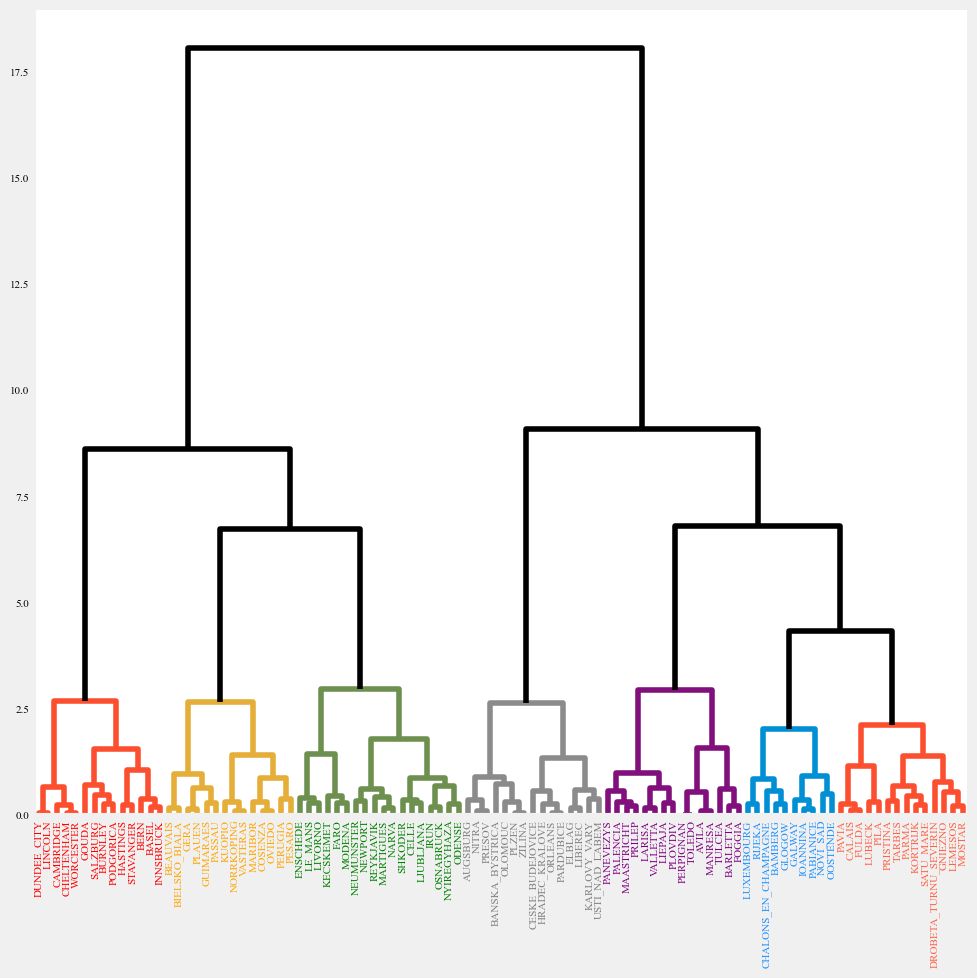

In [17]:
import matplotlib.pyplot as plt
import pandas as pd
import scipy.cluster.hierarchy as sch

plt.style.use('fivethirtyeight')
metrics = ['sqeuclidean']
color_threshold = 3

plt.rcParams["font.family"] = "Times New Roman"
output_folder = "outputs_HAC_normalize_SquareEuclidean_Ward"

# Define a color palette
color_palette = ["red", "orange", "green", "gray", "purple", "dodgerblue", "tomato"]  # Add more colors if needed

# Create a dataframe to store colors
color_df = pd.DataFrame(columns=['index', 'color'])

for distance_name in metrics:
    # Load the processed distance matrix from the CSV file
    processed_distance_matrix = pd.read_csv(f"{output_folder}/distance_{distance_name}.csv", index_col=0)

    # Perform hierarchical clustering
    linkage_matrix = sch.linkage(processed_distance_matrix, method='ward')

    # Create a figure and axis
    fig, ax = plt.subplots(figsize=(10, 10))

    # Plot the hierarchical clustering dendrogram
    dendrogram = sch.dendrogram(linkage_matrix, labels=processed_distance_matrix.index, orientation='top',
                                leaf_font_size=8, above_threshold_color='black', color_threshold=color_threshold)

    # Get the cluster labels for each data instance directly from the dendrogram
    cluster_labels = sch.fcluster(linkage_matrix, t=color_threshold, criterion='distance')

    # Create a dictionary to map cluster labels to colors
    cluster_color_dict = {label: color_palette[i % len(color_palette)] for i, label in enumerate(set(cluster_labels))}

    # Set colors for x-tick labels based on the cluster color dictionary and processed_distance_matrix.index
    for i, label in enumerate(processed_distance_matrix.index):
        cluster_label = cluster_labels[processed_distance_matrix.index.get_loc(label)]
        color = cluster_color_dict[cluster_label]
        for tick_label in ax.get_xticklabels():
            if tick_label.get_text() == label:
                tick_label.set_color(color)
                color_df = pd.concat([color_df, pd.DataFrame([(label, color)], columns=['index', 'color'])], ignore_index=True)

    # Set labels for x and y axes
    ax.set_xlabel('Cities', fontsize=12)

    # Adjust the plot's appearance
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.grid(False)  # Remove the grid
    ax.xaxis.set_tick_params(labelsize=8)
    ax.yaxis.set_tick_params(labelsize=8)

    plt.xlabel('')
    plt.ylabel('')

    ax.set_facecolor('white')

    # Tighten the layout
    plt.tight_layout()

    # Save the hierarchical clustering plot as a PDF file
    plt.savefig(f"{output_folder}/HAC_{distance_name}.pdf", format='pdf', bbox_inches='tight')

# Save the color dataframe to a CSV file
color_df.to_csv("color_data.csv", index=False)

### Plot the scatter for all selected cities from the UMAP coordinators and color from the HAC

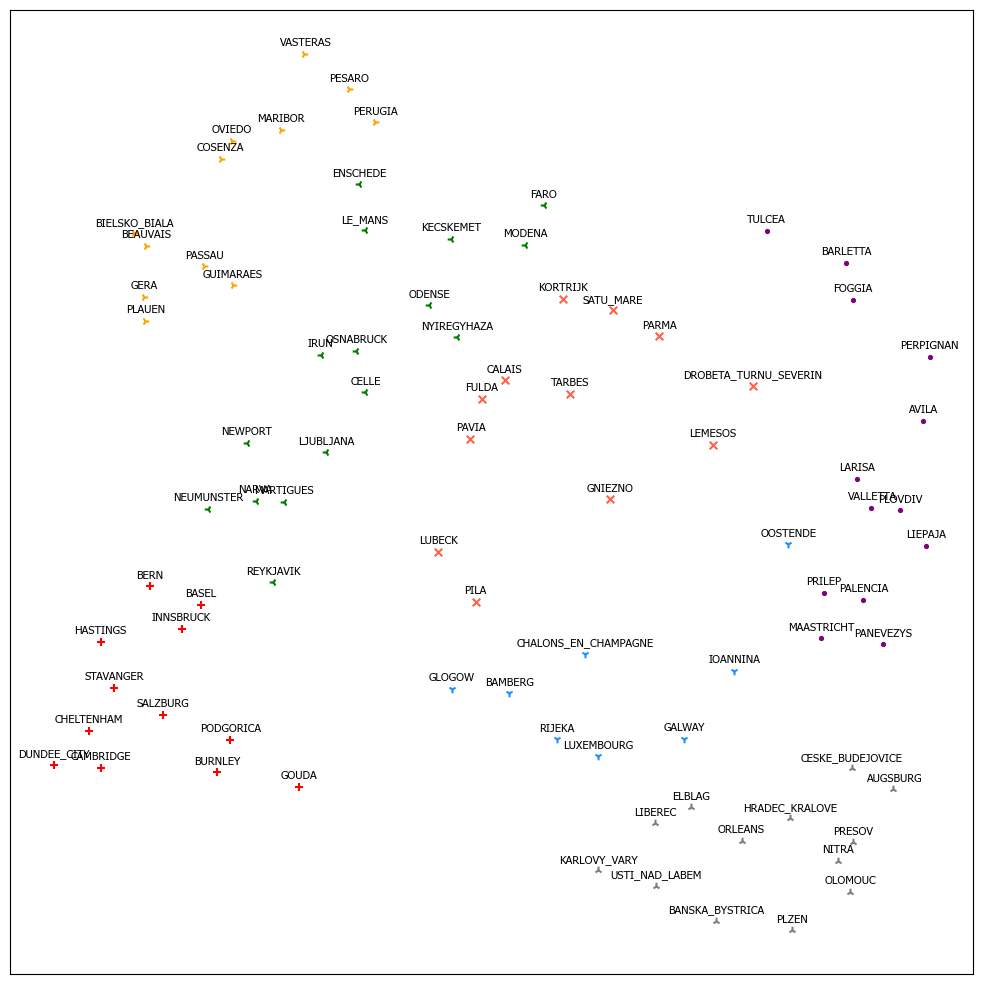

In [9]:
# plt.style.use('fivethirtyeight')

# Load the data
output_folder = "outputs_HAC_normalize_SquareEuclidean_Ward"

# Load the selected cities data
df_embedding = pd.read_csv("selected_cities.csv", index_col=2)

# Load the color data
df_colors = pd.read_csv("color_data.csv", index_col=0)

# Convert "file" column to uppercase and remove ".jpg" extension
df_embedding.index = df_embedding.index.str.upper().str.replace(".JPG", "")

# Merge the dataframes on the city index
df_merged = pd.merge(df_embedding, df_colors, left_index=True, right_index=True)

# Define markers for each group
markers = ['1', '2', '3', '4', '.', '+', 'x']

# Set the figure size and font size
plt.rcParams['figure.figsize'] = [10, 10]

# Create the scatter plot with color-coded clusters
fig, ax = plt.subplots()

# Group by color and plot scatter plots
for color, group in df_merged.groupby('color'):
    marker = markers.pop(0)  # Pick the next marker
    plt.scatter(group['x_coors'], group['y_coors'], s=30, c=color, marker=marker)

# Annotate data points with city names
for city, row in df_embedding.iterrows():
    x = df_embedding.loc[city, "x_coors"]
    y = df_embedding.loc[city, "y_coors"]
    ax.text(x, y+0.03, city, size=8, fontname='Tahoma', ha='center', va='bottom', color='black')

# Set plot title and labels
plt.xticks([])
plt.yticks([])
# plt.box(True)

# Remove the grid lines inside the scatter plot
ax.xaxis.grid(False)
ax.yaxis.grid(False)

# Save and show the plot
plt.tight_layout()
plt.savefig(f"{output_folder}/scatter.pdf", dpi=300)
plt.show()